# Fully-Connected VAE - Grid Search Params

The aim of this notebook is to grid search over `batchsize`, `lr`, `hidden layers` and `latent dimensions`:
* `batchsize`: A smaller batch size has *seemed* to help out with training. We want to test small, medium and large. The smaller, more network updates the larger less. 
* `lr`: The learning rate can influence a model's training significantly.
* `latent dimensions`: A larger latent space *should* be able to capture more information. However, there is likely to be a trade-off between complexity of network and improvement on reconstructions / generations and also as the data is bianry and quite "simple" (as shown by the FCVAE's ability to outperform the convolutional-VAE), a larger latent dimension may hinder the network's ability to constrict the important information.
* `hidden layers`: More layers are better? Similar motivation to the above, we are trying to see if we can achieve good reconstruction and generation using less layers - Occam's Razor.


We will run a gridsearch for each combination for 10 epochs. We will store the lowest `MSE("sum")` reconstruction loss between the model and the training data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from livelossplot import PlotLosses
from torch.utils.data import DataLoader
from tqdm import tqdm

from atlaswildfiretool.generative.utils import (
    get_device,
    sequential_undersample_3d_arr,
    sequential_train_val_split,
)

from atlaswildfiretool.generative.plotting import (
    plot_batch_recon_images,
    plot_single_raw_and_dataset_idx_image,
    generate_images_from_latent_space_vectors,
    plot_generated_images_from_latent_space,
)

from atlaswildfiretool.generative.model import VAE, GridSearchVAE
from atlaswildfiretool.generative.training import train, validate, train_vae, save_checkpoint

from atlaswildfiretool.generative.dataset import WildfireImageDataSet

%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
DEVICE = get_device()

No GPU available! (device = cpu)


#### Data Loading
* A user will need to download the wildfire data available at `https://companyname.sharepoint.com/sites/projectname/Shared%20Documents/example-document.docx`
* the current set up runs given that the `.npy` wildfire data is stored in a `data/` DIR.

In [3]:
# load in the data.
train_data = np.load("data/Ferguson_fire_train.npy")
test_data = np.load(f"data/Ferguson_fire_test.npy")

print("** (raw) DATA INFO **")
print(f"train: type={type(train_data)}, dims={train_data.shape}")
print(f"test: type={type(test_data)}, dims={test_data.shape}")

** (raw) DATA INFO **
train: type=<class 'numpy.ndarray'>, dims=(12500, 256, 256)
test: type=<class 'numpy.ndarray'>, dims=(5000, 256, 256)


* undersampling the training data (if needed) to help speed up the model training. 
* there are 12500 images in the raw training data, containing a number of ~ 100 length wildfires. Undersampling them sequentially means we still capture the temporal relationships and the data characteristics / distributions at all points in the wildfire sequence.

In [4]:
train_data_us = sequential_undersample_3d_arr(arr=train_data, sequence_jump=1)

X_train, X_val = sequential_train_val_split(
    train_data=train_data_us, sequence_jump=3, start_offset=2, jump_multiplier=3
)


** (undersampled) data info **
X_train_undersampled: (12500, 256, 256)

** (split) data info (w/ jump=3)**
X_train: (11111, 256, 256)
X_val: (1389, 256, 256)


In [5]:
transform = transforms.Compose(
    transforms=[
        transforms.ToTensor(),
    ]
)

train_dataset = WildfireImageDataSet(data=X_train, transform=transform)
val_dataset = WildfireImageDataSet(data=X_val, transform=transform)
test_dataset = WildfireImageDataSet(data=test_data, transform=transform)

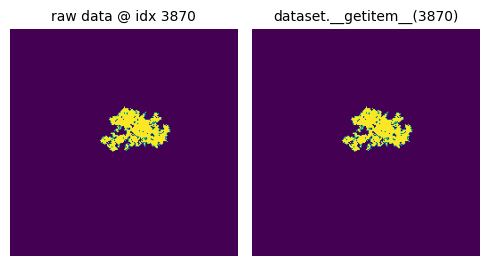

In [6]:
plot_single_raw_and_dataset_idx_image(
    data=X_train,
    dataset=train_dataset,
    idx=3870,
    figsize=(5, 3),
    # cmap="hot",
)

* set the `batch_size` and create the `dataloaders`

In [7]:
# KEY PARAMETERS for DATA
batch_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

### Grid Search...

* validating / making sure that the `VAE()` using the "baseline" setup: `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batch size=32` return ~ expected training and val graphs for 5 epochs.

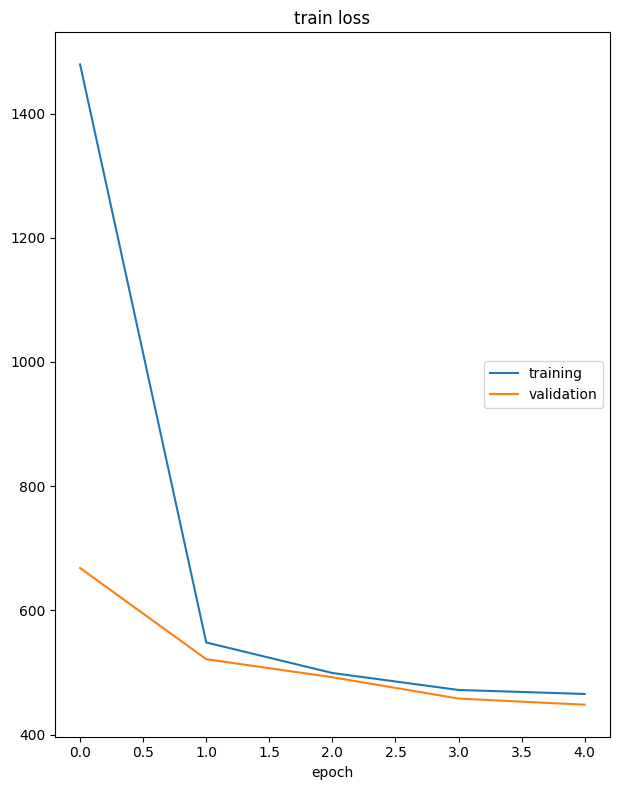

Epoch: 4/5 | Batch: 348/348: 100%|██████████| 1740/1740 [00:54<00:00, 31.72batch/s, loss=754]

train loss
	training         	 (min:  465.492, max: 1479.217, cur:  465.492)
	validation       	 (min:  448.191, max:  668.317, cur:  448.191)


In [33]:
model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.ReLU,
    device=DEVICE,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)

model, train_losses, val_losses = train_vae(
    n_epochs=5,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path="model_test.pt",
    use_liveloss=True,
)

random idxs = tensor([ 4, 19, 18, 10, 18])


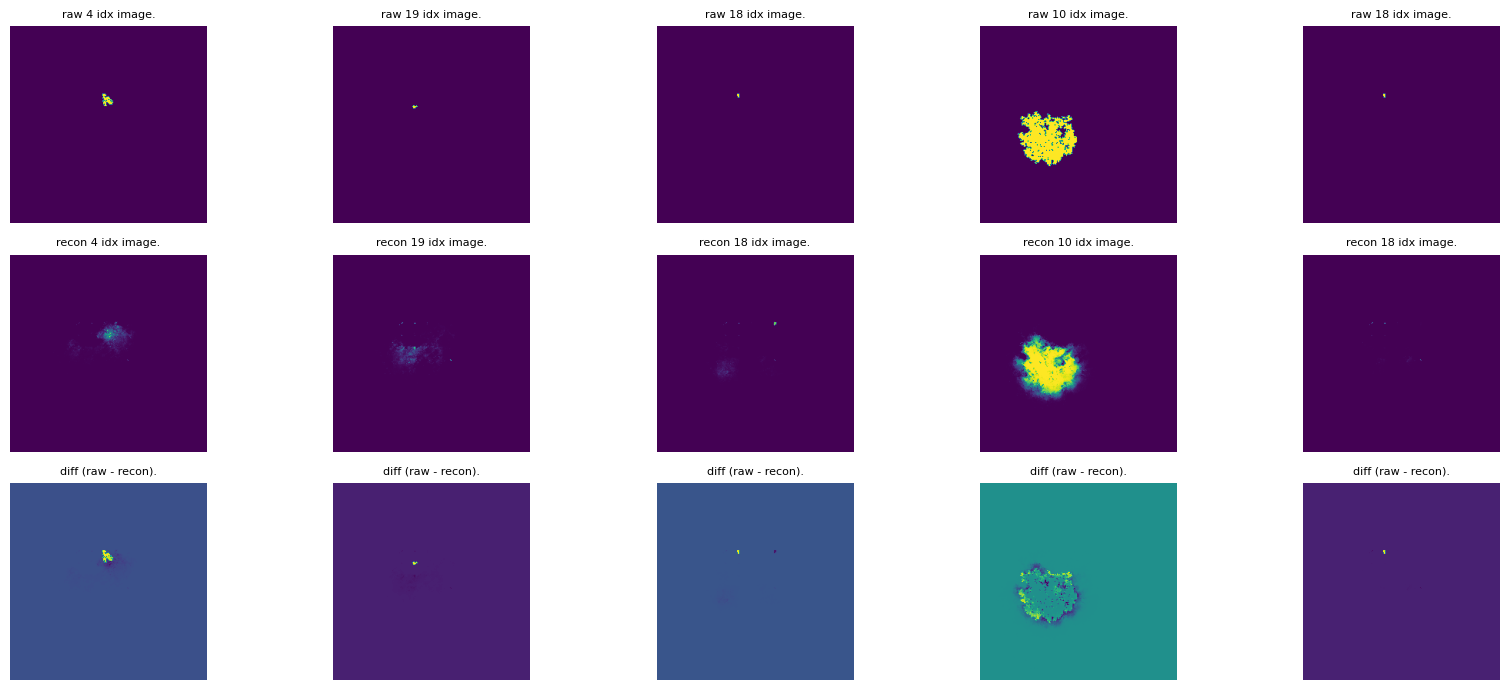

In [16]:
plot_batch_recon_images(
    model=model,
    data_loader=train_loader,
    num_images=5,
    device=DEVICE,
)

* Plotting the training recons...as expected, after 5 epochs, the model recons are not amazing. It is able to capture a lot of the spatial information from the larger wildfires as you can see in the 4th image (from left to right)

* for the grid search, we kept all the training data - no undersampling. We kept all the training data with ~ 10% val - this was to ensure that we werent overfitting and that our training and val graphs were non-divergent.
* Also, as we did the grid search after attempting a CNN-VAE (`CNNVAE_Tuning.ipynb`) and after a few explorations of fully connected arcitechtures. As briefly outline at the start of `FCVAE_Tuning.ipynb`, we quickly found that `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU()` was performing very well at recons and image generation and so for this we wanted to keep all the data to improve the reliability of our results.

In [16]:
grid_search = GridSearchVAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[
        (512, 256, 128),
        (1024, 512, 256),
        (1024, 256, 128),
        (1024, 128),
    ],  # modifying layers: [baseline*, 2*baseline, increase initial dim, 2 layers]
    latent_dims=[16, 32, 64],  # 4 different latent dims.
    batch_sizes=[8, 32, 64],  # modifing batchsize.
    lrs=[
        1e-3
    ],  # modifying lr -> fixing it due to grid search size (previous small experiments have indicated that this lr is the most stable and performs best).
    epochs=10,
    device=DEVICE,
)

grid_search.fit(train_dataset, val_dataset)


** Experiment: latent_dim=16,hidden_layers=(512, 256, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:36<00:00, 38.57batch/s, loss=641]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.76batch/s, loss=411]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.73batch/s, loss=289]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.75batch/s, loss=657]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.73batch/s, loss=387]    
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.68batch/s, loss=391]    
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.74batch/s, loss=427]  
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.69batch/s, loss=433]    
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.66batch/s, loss=285]    
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.68batch/s, loss=4


** Experiment: latent_dim=16,hidden_layers=(1024, 512, 256), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.07batch/s, loss=622]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.08batch/s, loss=842]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.07batch/s, loss=516]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.07batch/s, loss=336]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.07batch/s, loss=494]  
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.16batch/s, loss=627]    
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.07batch/s, loss=249]    
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.08batch/s, loss=799]  
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.07batch/s, loss=590]    
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:09<00:00, 20.08batch/s, loss=732


** Experiment: latent_dim=16,hidden_layers=(1024, 256, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.26batch/s, loss=50.9]   
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.45batch/s, loss=637]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=857]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=463]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=186]  
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.47batch/s, loss=631]  
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=402]  
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=373]  
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.47batch/s, loss=284]    
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=369]  



** Experiment: latent_dim=16,hidden_layers=(1024, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.58batch/s, loss=921]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=248]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=213]  
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=335]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.52batch/s, loss=217]    
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.34batch/s, loss=118] 
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=526]  
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=377] 
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=341] 
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=293]    



** Experiment: latent_dim=16,hidden_layers=(512, 256, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.00batch/s, loss=603]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.95batch/s, loss=686]
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.01batch/s, loss=530]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.03batch/s, loss=576]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.12batch/s, loss=286]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.08batch/s, loss=822]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.05batch/s, loss=418]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.98batch/s, loss=756]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.18batch/s, loss=310]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.11batch/s, loss=290]



** Experiment: latent_dim=16,hidden_layers=(1024, 512, 256), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.67batch/s, loss=735]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=340]
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.64batch/s, loss=292]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.65batch/s, loss=609]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.66batch/s, loss=383]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.67batch/s, loss=257]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.67batch/s, loss=198]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.66batch/s, loss=748]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.65batch/s, loss=218]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.66batch/s, loss=174]



** Experiment: latent_dim=16,hidden_layers=(1024, 256, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.80batch/s, loss=554]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=698]  
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=694]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=352]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=407]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.80batch/s, loss=520]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.79batch/s, loss=374]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.79batch/s, loss=559]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.77batch/s, loss=534]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.76batch/s, loss=368]



** Experiment: latent_dim=16,hidden_layers=(1024, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=176]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.91batch/s, loss=615]
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.89batch/s, loss=792]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.90batch/s, loss=363]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.90batch/s, loss=97.1]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.90batch/s, loss=330]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=293]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.91batch/s, loss=367]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.91batch/s, loss=415]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.91batch/s, loss=106]



** Experiment: latent_dim=16,hidden_layers=(512, 256, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.17batch/s, loss=710]    
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.25batch/s, loss=581]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.26batch/s, loss=558]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.24batch/s, loss=561]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.26batch/s, loss=619]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.20batch/s, loss=354]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.24batch/s, loss=400]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.17batch/s, loss=428]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.17batch/s, loss=388]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.07batch/s, loss=436]



** Experiment: latent_dim=16,hidden_layers=(1024, 512, 256), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.70batch/s, loss=1.14e+3]
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.73batch/s, loss=561]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.73batch/s, loss=487]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.74batch/s, loss=365]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.74batch/s, loss=529]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.70batch/s, loss=511]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.73batch/s, loss=409]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.72batch/s, loss=492]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.73batch/s, loss=356]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.69batch/s, loss=410]



** Experiment: latent_dim=16,hidden_layers=(1024, 256, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.79batch/s, loss=904]    
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.81batch/s, loss=558]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.78batch/s, loss=404]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.82batch/s, loss=445]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.75batch/s, loss=392]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.79batch/s, loss=604]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.77batch/s, loss=497]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.78batch/s, loss=406]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.79batch/s, loss=379]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.81batch/s, loss=370]



** Experiment: latent_dim=16,hidden_layers=(1024, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.91batch/s, loss=603]    
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.94batch/s, loss=548]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.92batch/s, loss=441]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.93batch/s, loss=483]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.91batch/s, loss=396]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.88batch/s, loss=514]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.93batch/s, loss=275]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.92batch/s, loss=249]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.92batch/s, loss=304]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.89batch/s, loss=212]



** Experiment: latent_dim=32,hidden_layers=(512, 256, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.47batch/s, loss=408]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.47batch/s, loss=774]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.45batch/s, loss=553]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.46batch/s, loss=449]  
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.47batch/s, loss=272]  
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.46batch/s, loss=235]    
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.45batch/s, loss=416]    
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.80batch/s, loss=135]    
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 38.64batch/s, loss=314]    
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.50batch/s, loss=222


** Experiment: latent_dim=32,hidden_layers=(1024, 512, 256), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.38batch/s, loss=823]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=928]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=808]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=650]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=95.8]   
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.38batch/s, loss=230]    
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=492]    
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=261]    
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=311]  
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=2


** Experiment: latent_dim=32,hidden_layers=(1024, 256, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=367]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.45batch/s, loss=433]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=929]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.44batch/s, loss=1.31e+3]
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.47batch/s, loss=686]    
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.47batch/s, loss=197]  
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=606]    
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=498]  
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=166]  
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.47batch/s, loss=235] 


** Experiment: latent_dim=32,hidden_layers=(1024, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.58batch/s, loss=254]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=466]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=463]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=458]  
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=208]  
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=745]  
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=171]    
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=359]  
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.58batch/s, loss=234] 
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.58batch/s, loss=381] 



** Experiment: latent_dim=32,hidden_layers=(512, 256, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.05batch/s, loss=671]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.07batch/s, loss=460]  
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.97batch/s, loss=459]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.99batch/s, loss=599]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.00batch/s, loss=563]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.99batch/s, loss=395]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 37.07batch/s, loss=507]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.99batch/s, loss=568]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.96batch/s, loss=283]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.98batch/s, loss=422]



** Experiment: latent_dim=32,hidden_layers=(1024, 512, 256), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=1.29e+3]
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.69batch/s, loss=614]
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.64batch/s, loss=614]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.66batch/s, loss=694]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.66batch/s, loss=386]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.66batch/s, loss=844]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.66batch/s, loss=508]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=516]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.67batch/s, loss=220]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.65batch/s, loss=526]



** Experiment: latent_dim=32,hidden_layers=(1024, 256, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.80batch/s, loss=705]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.80batch/s, loss=747]
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.76batch/s, loss=318]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.79batch/s, loss=519]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.79batch/s, loss=300]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=530]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.79batch/s, loss=466]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=349]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=469]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.77batch/s, loss=307]



** Experiment: latent_dim=32,hidden_layers=(1024, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=266]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=467]
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.91batch/s, loss=436]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.90batch/s, loss=480]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.90batch/s, loss=252]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=513]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.74batch/s, loss=308]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.53batch/s, loss=401]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.54batch/s, loss=156]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.57batch/s, loss=303]



** Experiment: latent_dim=32,hidden_layers=(512, 256, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.27batch/s, loss=1.31e+3]
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.27batch/s, loss=537]    
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.30batch/s, loss=592]  
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.18batch/s, loss=664]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.13batch/s, loss=439]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.13batch/s, loss=515]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.16batch/s, loss=438]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.15batch/s, loss=585]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 33.88batch/s, loss=563]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.13batch/s, loss=522]



** Experiment: latent_dim=32,hidden_layers=(1024, 512, 256), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.67batch/s, loss=1.73e+3]
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.69batch/s, loss=853]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.72batch/s, loss=663]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.72batch/s, loss=481]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.70batch/s, loss=628]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.70batch/s, loss=554]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.69batch/s, loss=494]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.69batch/s, loss=444]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.71batch/s, loss=471]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.72batch/s, loss=444]



** Experiment: latent_dim=32,hidden_layers=(1024, 256, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.77batch/s, loss=808]    
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.78batch/s, loss=550]
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.81batch/s, loss=490]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.72batch/s, loss=573]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.76batch/s, loss=415]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.78batch/s, loss=405]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.80batch/s, loss=674]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.77batch/s, loss=321]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.80batch/s, loss=433]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.77batch/s, loss=442]



** Experiment: latent_dim=32,hidden_layers=(1024, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.86batch/s, loss=543]    
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.88batch/s, loss=597]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.87batch/s, loss=432]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.85batch/s, loss=476]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.90batch/s, loss=385]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.89batch/s, loss=542]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.86batch/s, loss=499]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.89batch/s, loss=405]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.88batch/s, loss=369]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.85batch/s, loss=329]



** Experiment: latent_dim=64,hidden_layers=(512, 256, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.43batch/s, loss=985]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.47batch/s, loss=489]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.43batch/s, loss=404]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.46batch/s, loss=723]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.47batch/s, loss=489]    
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.42batch/s, loss=692]    
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.48batch/s, loss=427]    
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.47batch/s, loss=282]    
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.44batch/s, loss=436]
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [00:35<00:00, 39.43batch/s, loss=566


** Experiment: latent_dim=64,hidden_layers=(1024, 512, 256), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.36batch/s, loss=297]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.36batch/s, loss=271]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=304]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=384]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.35batch/s, loss=338]    
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=493]  
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.36batch/s, loss=365]    
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.36batch/s, loss=386]    
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=650]    
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:08<00:00, 20.37batch/s, loss=6


** Experiment: latent_dim=64,hidden_layers=(1024, 256, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=587]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.45batch/s, loss=204]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=601]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.45batch/s, loss=376]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=585]    
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=456]    
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=325]    
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=492]  
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=120]  
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.46batch/s, loss=513


** Experiment: latent_dim=64,hidden_layers=(1024, 128), batch_size=8 @ lr=0.001 **


Epoch: 0/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=988]    
Epoch: 1/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=677]    
Epoch: 2/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=471]    
Epoch: 3/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=614]    
Epoch: 4/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=588]    
Epoch: 5/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.57batch/s, loss=450]    
Epoch: 6/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=251] 
Epoch: 7/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=236]    
Epoch: 8/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.56batch/s, loss=349]    
Epoch: 9/10 | Batch: 1389/1389: 100%|██████████| 1389/1389 [01:07<00:00, 20.45batch/s, loss=41


** Experiment: latent_dim=64,hidden_layers=(512, 256, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.20batch/s, loss=971]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.21batch/s, loss=388]  
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.10batch/s, loss=519]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.17batch/s, loss=621]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.15batch/s, loss=342]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.15batch/s, loss=875]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.13batch/s, loss=916]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.20batch/s, loss=524]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.17batch/s, loss=687]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:09<00:00, 36.25batch/s, loss=719]



** Experiment: latent_dim=64,hidden_layers=(1024, 512, 256), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.70batch/s, loss=396]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=461]    
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=770]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=286]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=986]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.66batch/s, loss=375]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=749]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.68batch/s, loss=811]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.69batch/s, loss=389]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.69batch/s, loss=316]



** Experiment: latent_dim=64,hidden_layers=(1024, 256, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.79batch/s, loss=117]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.82batch/s, loss=525]  
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=696]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.79batch/s, loss=338]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=676]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.80batch/s, loss=590]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=467]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.79batch/s, loss=342]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.78batch/s, loss=484]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.80batch/s, loss=428]



** Experiment: latent_dim=64,hidden_layers=(1024, 128), batch_size=32 @ lr=0.001 **


Epoch: 0/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.90batch/s, loss=492]    
Epoch: 1/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.93batch/s, loss=543]
Epoch: 2/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.91batch/s, loss=317]
Epoch: 3/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.91batch/s, loss=366]
Epoch: 4/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.89batch/s, loss=555]
Epoch: 5/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=539]
Epoch: 6/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=447]
Epoch: 7/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.91batch/s, loss=354]
Epoch: 8/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=177]
Epoch: 9/10 | Batch: 348/348: 100%|██████████| 348/348 [00:17<00:00, 19.92batch/s, loss=394]



** Experiment: latent_dim=64,hidden_layers=(512, 256, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.10batch/s, loss=1.12e+3]
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.19batch/s, loss=746]    
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.30batch/s, loss=627]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.31batch/s, loss=535]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.30batch/s, loss=580]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.28batch/s, loss=497]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.20batch/s, loss=545]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.25batch/s, loss=518]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.30batch/s, loss=384]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:05<00:00, 34.18batch/s, loss=370]



** Experiment: latent_dim=64,hidden_layers=(1024, 512, 256), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.73batch/s, loss=1.14e+3]
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.71batch/s, loss=784]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.75batch/s, loss=567]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.74batch/s, loss=428]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.74batch/s, loss=577]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.72batch/s, loss=583]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.69batch/s, loss=453]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.74batch/s, loss=501]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.71batch/s, loss=384]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.72batch/s, loss=507]



** Experiment: latent_dim=64,hidden_layers=(1024, 256, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.81batch/s, loss=1.75e+3]
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.81batch/s, loss=534]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.82batch/s, loss=362]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.84batch/s, loss=520]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.76batch/s, loss=445]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.82batch/s, loss=513]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.81batch/s, loss=428]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.82batch/s, loss=520]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.77batch/s, loss=507]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.79batch/s, loss=463]



** Experiment: latent_dim=64,hidden_layers=(1024, 128), batch_size=64 @ lr=0.001 **


Epoch: 0/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.90batch/s, loss=933]    
Epoch: 1/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.90batch/s, loss=493]  
Epoch: 2/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.90batch/s, loss=519]
Epoch: 3/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.92batch/s, loss=446]
Epoch: 4/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.86batch/s, loss=481]
Epoch: 5/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.86batch/s, loss=426]
Epoch: 6/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.90batch/s, loss=330]
Epoch: 7/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.87batch/s, loss=364]
Epoch: 8/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.91batch/s, loss=387]
Epoch: 9/10 | Batch: 174/174: 100%|██████████| 174/174 [00:09<00:00, 18.91batch/s, loss=339]


In [17]:
grid_search.best_params

{'latent_dim': 16,
 'batch_size': 32,
 'layers': (1024, 128),
 'learning_rate': 0.001,
 'train_loss': 254.14788789245316,
 'val_loss': 253.745550014202,
 'epoch': 9}

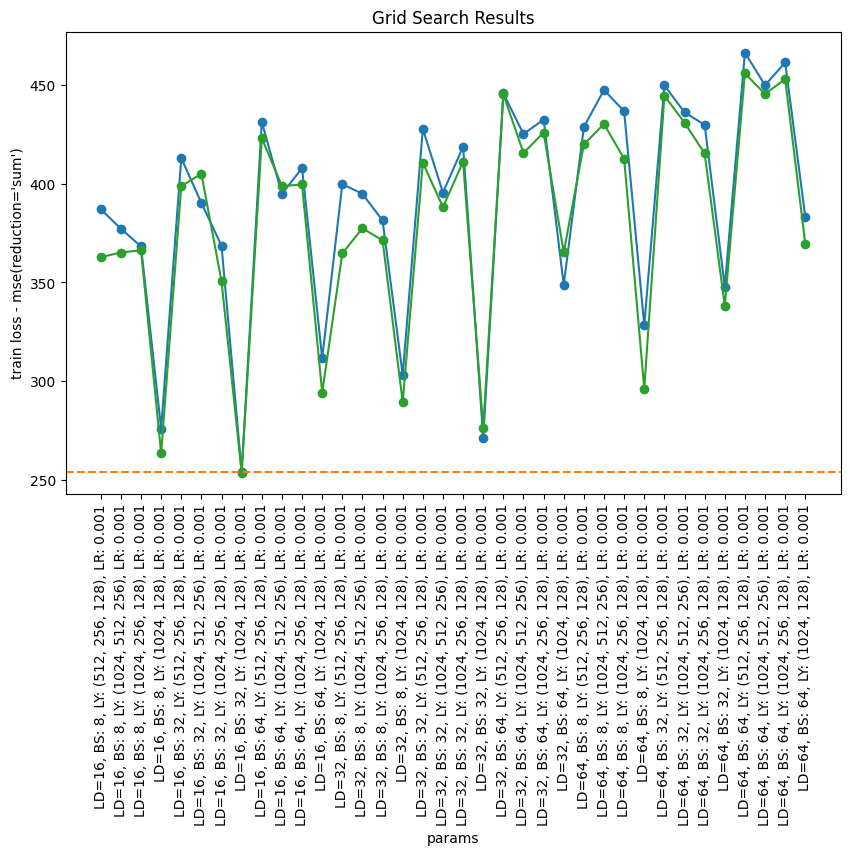

In [18]:
grid_search.plot_results()

* the winner is a very small 2 layer network but keeping the latent dims @ 16: `[1024 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize=32`

* As you can see, a lot of the scores are between 200 and 300 and we were only able to run the grid search for 10 epochs. Because of this, we decided that we will continue with some further testing but only with the previous "baseline" and the new "best" model:

  * winner: `[1024 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize=32`
  * previous "baseline": `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize = 32` 

  
For these 2 networks, we will run them both to 100 epochs and check the MSE, and the reconstructions. I will also test the `amsgrad` arg of the Adam() optimiser.

In [76]:
model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[1024, 128],
    latent_dims=16,
    activation=nn.ReLU,
    device=DEVICE,
).to(DEVICE)

* checking to see amsgrad=`True` or `False`. Grid search performed @ `False`.

In [77]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, amsgrad=False
)  # setting to false (default).

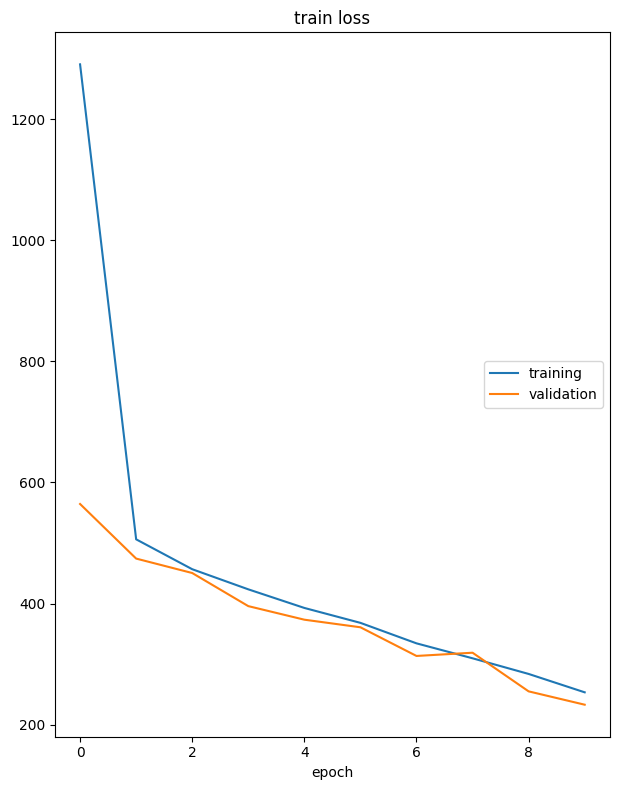

Epoch: 9/10 | Batch: 348/348: 100%|██████████| 3480/3480 [03:25<00:00, 16.97batch/s, loss=150]

train loss
	training         	 (min:  253.370, max: 1290.356, cur:  253.370)
	validation       	 (min:  232.920, max:  564.357, cur:  232.920)


In [78]:
model, train_losses, val_losses = train_vae(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
)

The results - taken a copy of both of the training results after 10 epochs:

* amsgrad = `True`:
    ```
        # Epoch: 9/10 | Batch: 348/348: 100%|██████████| 3480/3480 [04:03<00:00, 14.31batch/s, loss=235]
        # train loss
        # 	training         	 (min:  282.076, max: 1101.511, cur:  282.076)
        # 	validation       	 (min:  281.638, max:  546.736, cur:  281.638)
    ```

* amsgrad = `False`:
    ```
    # --> no AMS grad
    # Epoch: 9/10 | Batch: 348/348: 100%|██████████| 3480/3480 [03:25<00:00, 16.97batch/s, loss=150]
    # train loss
    # 	training         	 (min:  253.370, max: 1290.356, cur:  253.370)
    # 	validation       	 (min:  232.920, max:  564.357, cur:  232.920)
    ```

* decision to keep the defaul setting `amsgrad=False`.

### Further exploring the winner...

* we are now going to run the winner for 100 epochs to see how it performs after longer training:

[1]: Previous "baseline" `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize = 32`

In [18]:
model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[1024, 128],
    latent_dims=16,
    activation=nn.ReLU,
    device=DEVICE,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)

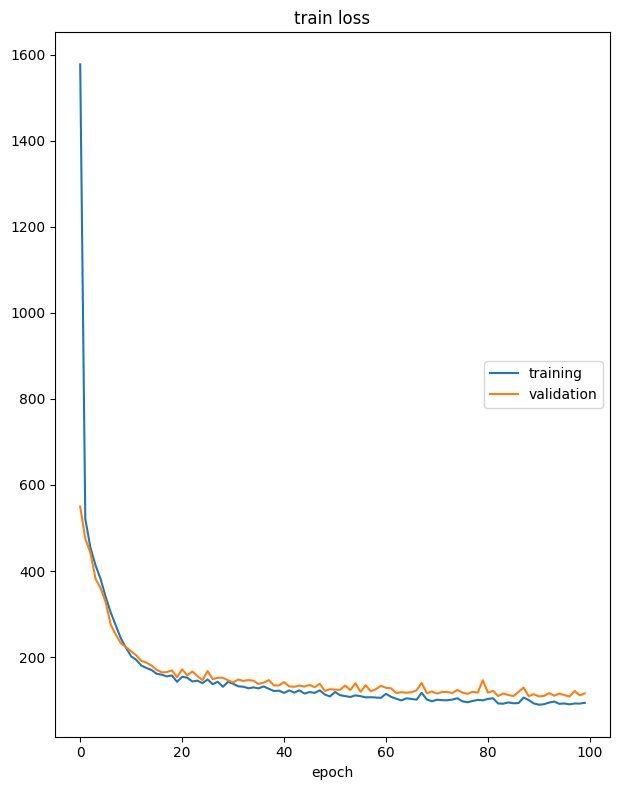

Epoch: 99/100 | Batch: 348/348: 100%|██████████| 34800/34800 [31:40<00:00, 18.31batch/s, loss=101] 

train loss
	training         	 (min:   89.442, max: 1577.188, cur:   93.771)
	validation       	 (min:  108.321, max:  549.669, cur:  115.577)


In [19]:
model, train_losses, val_losses = train_vae(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
)

random idxs = tensor([13, 13, 17, 27,  8, 29,  3, 11])


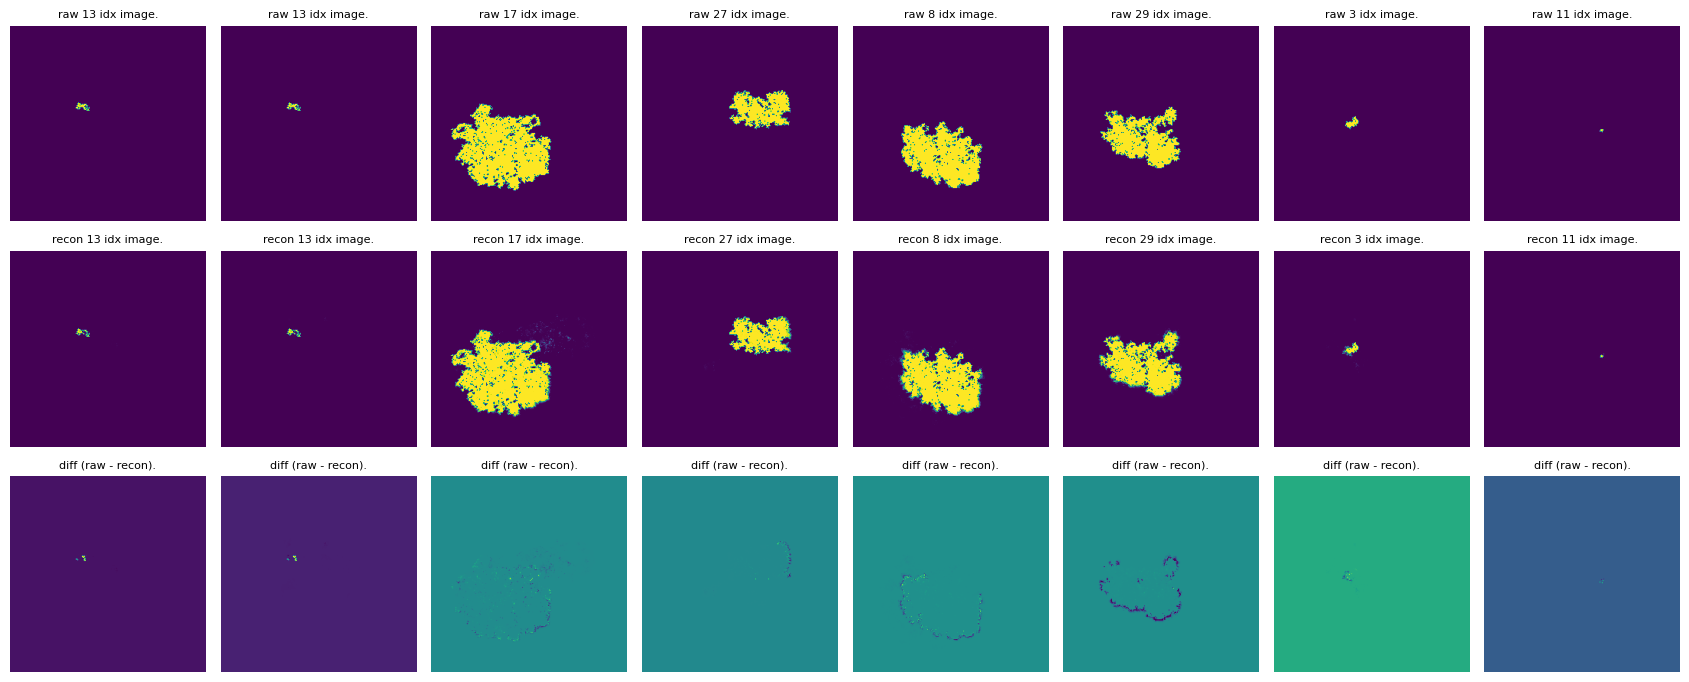

In [26]:
plot_batch_recon_images(
    model=model,
    data_loader=train_loader,
    num_images=8,
    device=DEVICE,
)

random idxs = tensor([ 7, 12, 27, 17, 24, 12,  8,  6])


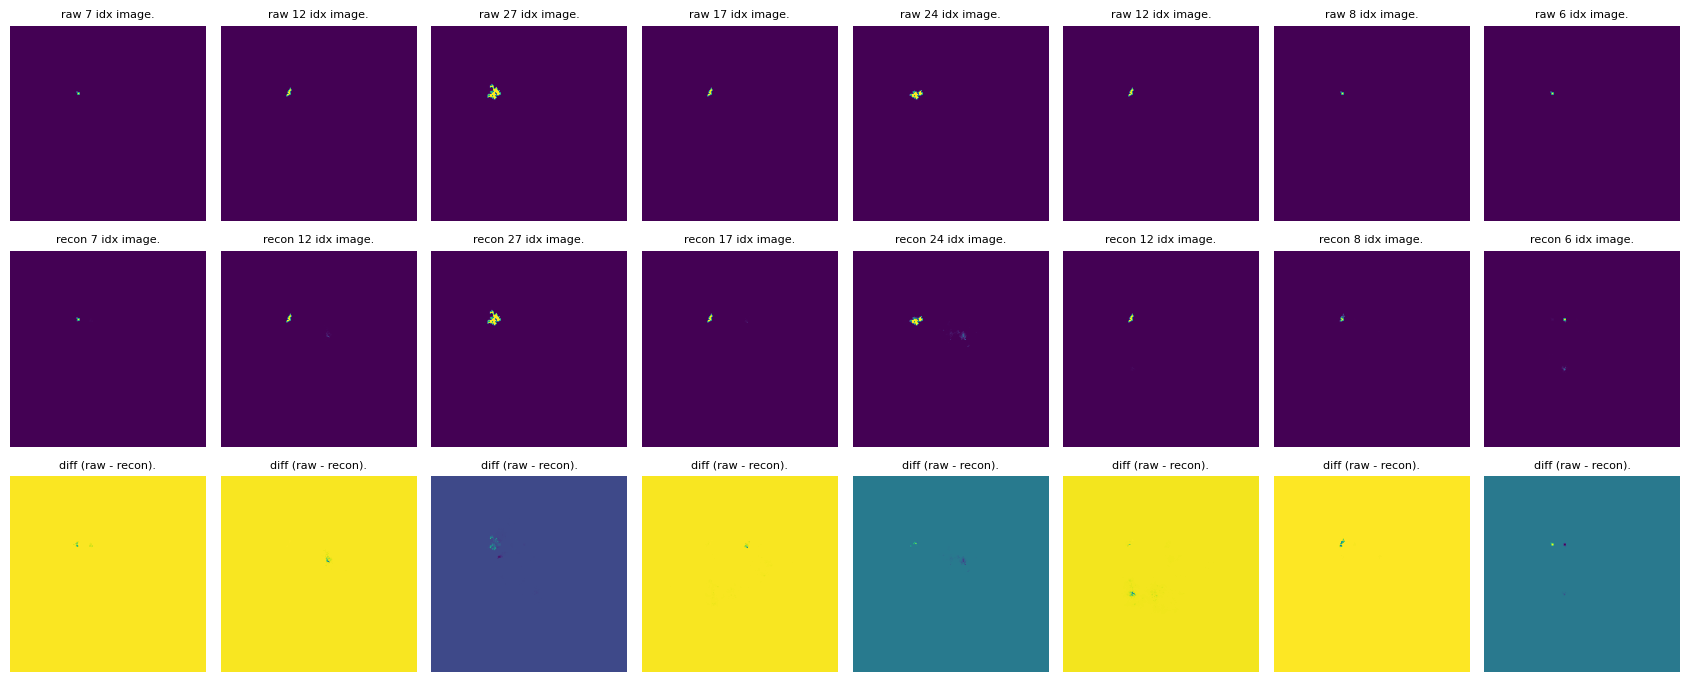

In [27]:
plot_batch_recon_images(
    model=model,
    data_loader=val_loader,
    num_images=8,
    device=DEVICE,
)

* training and val are not divergent, the training is stable and the lowest mse between recons and train was: **89.442**
* the recons looks good - especially the training data.

### Adding in improvements...

* in the notebook `FCVAE_Tuning.ipynb` we identified that a learning rate scheduler and the ELU activation showed promising signs after 20 epochs when compared to the previous "baseline" - `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize = 32`. To that end, we are running the "winner" arch using these individually to see if they help the model:

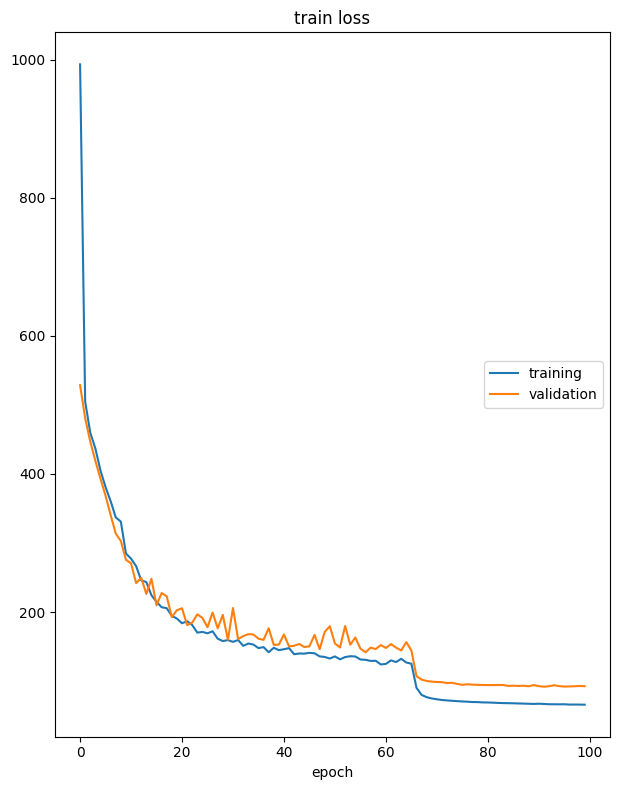

Epoch: 99/100 | Batch: 348/348: 100%|██████████| 34800/34800 [32:32<00:00, 17.82batch/s, loss=68.8]

train loss
	training         	 (min:   65.655, max:  993.641, cur:   65.655)
	validation       	 (min:   91.775, max:  528.690, cur:   92.508)


In [20]:
# adding in a ELU and the learning rate scheduler..

model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[1024, 128],
    latent_dims=16,
    activation=nn.ELU,  # <-- adding in ELU.
    device=DEVICE,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(  # <-- adding in lr schedule.
    optimizer, mode="min", factor=0.1, patience=5
)

model, train_losses, val_losses = train_vae(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=True,
)

* the learning rate scheduler definitely helps the model in training when it starts to plateau later on.
* `ELU` seems to make the training and validation less smooth. 

random idxs = tensor([20,  4, 14,  4,  6,  4, 16, 21])


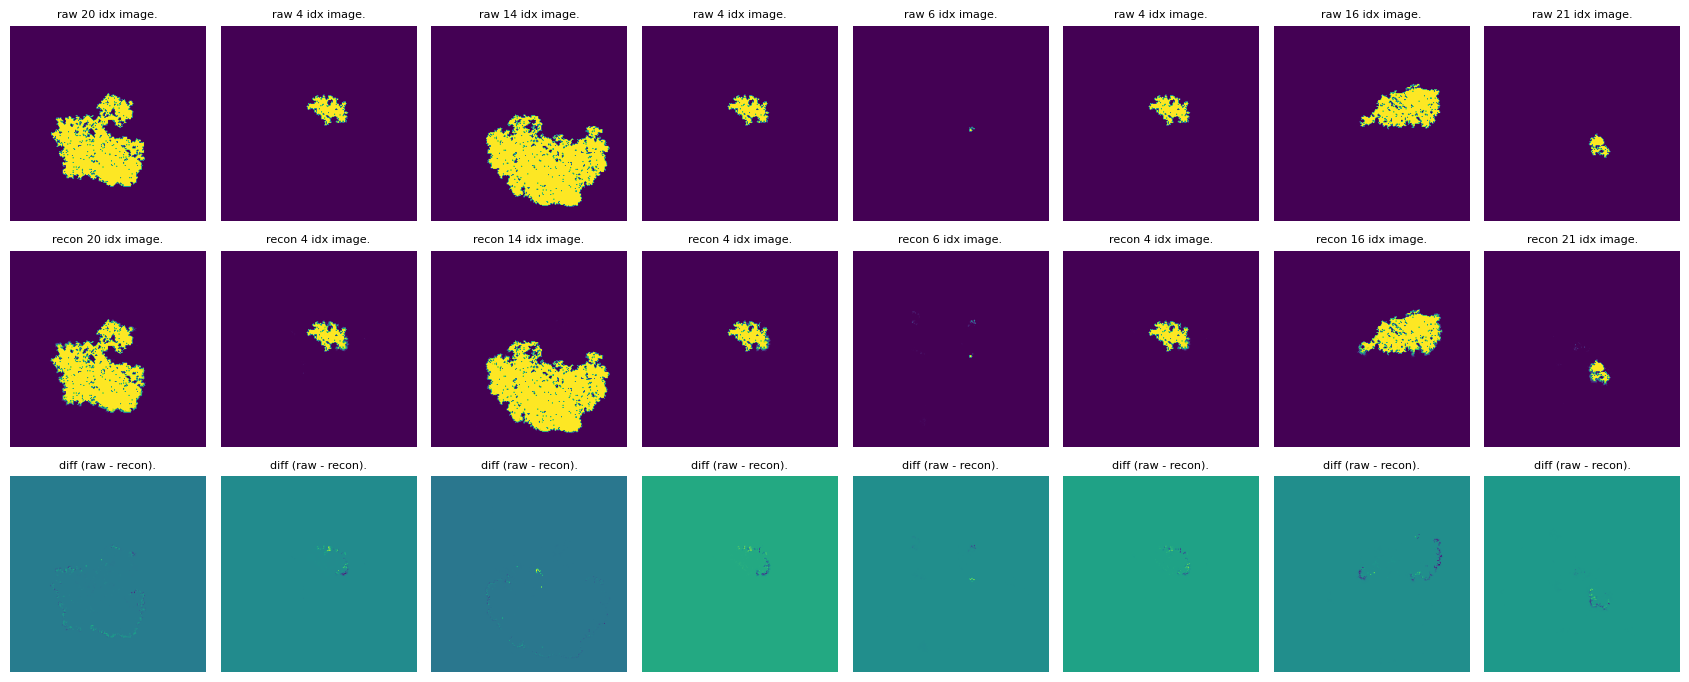

In [23]:
plot_batch_recon_images(
    model=model,
    data_loader=train_loader,
    num_images=8,
    device=DEVICE,
)

* there are some minor artefacts but on the whole this model performs very well at reconstructing the data.

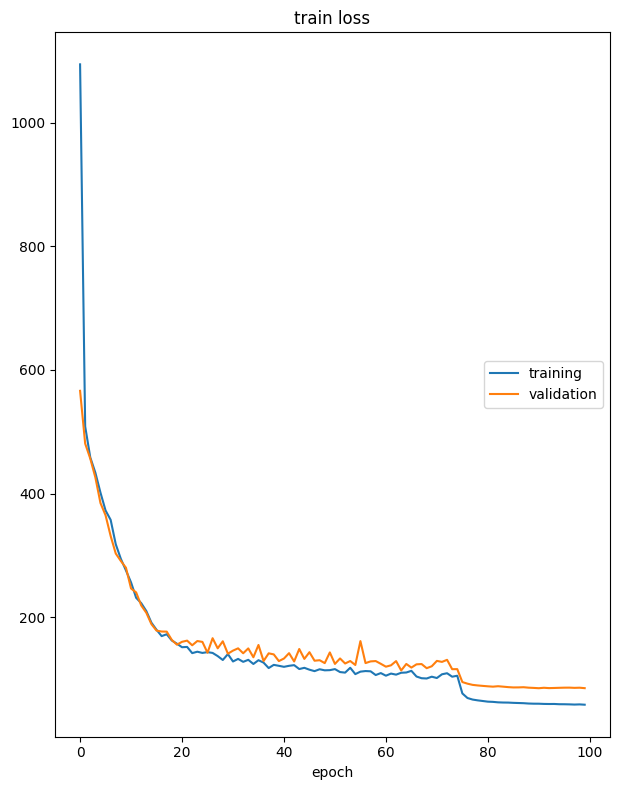

Epoch: 99/100 | Batch: 348/348: 100%|██████████| 34800/34800 [32:10<00:00, 18.03batch/s, loss=47.5]

train loss
	training         	 (min:   58.384, max: 1094.203, cur:   58.384)
	validation       	 (min:   85.059, max:  566.092, cur:   85.144)


In [25]:
# only learning rate scheduler...

model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[1024, 128],
    latent_dims=16,
    activation=nn.ReLU,  # back to RELU
    device=DEVICE,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)
scheduler = (
    torch.optim.lr_scheduler.ReduceLROnPlateau(  # <-- keeping in the learning rate
        optimizer, mode="min", factor=0.1, patience=5
    )
)

model, train_losses, val_losses = train_vae(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path="model_test_relu.pt",
    use_liveloss=True,
)

* relu seems to outperform ELU, more stable and lower MSE.

random idxs = tensor([28,  2, 25,  7, 20, 17, 30,  6])


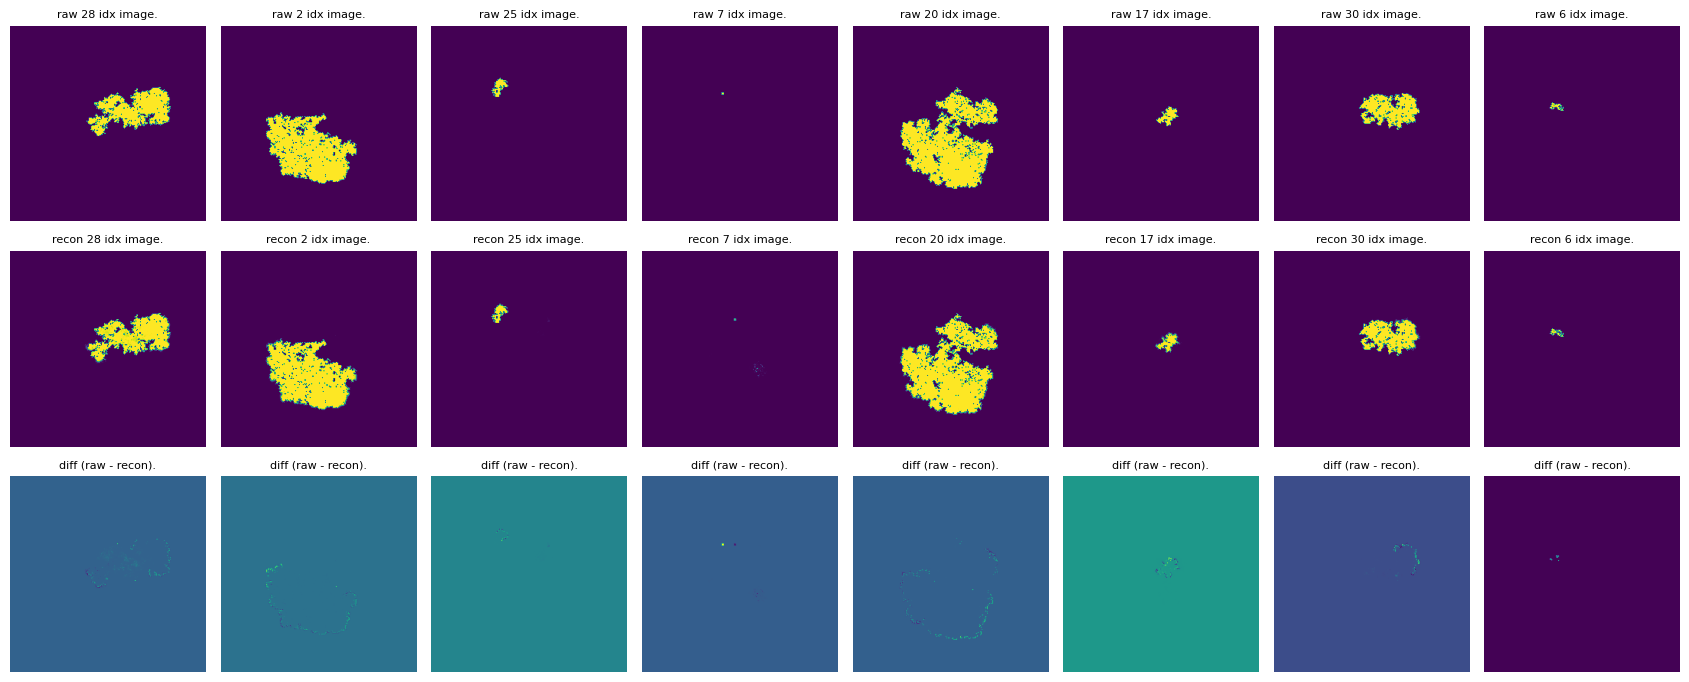

In [53]:
plot_batch_recon_images(
    model=model,
    data_loader=train_loader,
    num_images=8,
    device=DEVICE,
)

random idxs = tensor([10,  0, 17, 29, 25, 12, 12,  7])


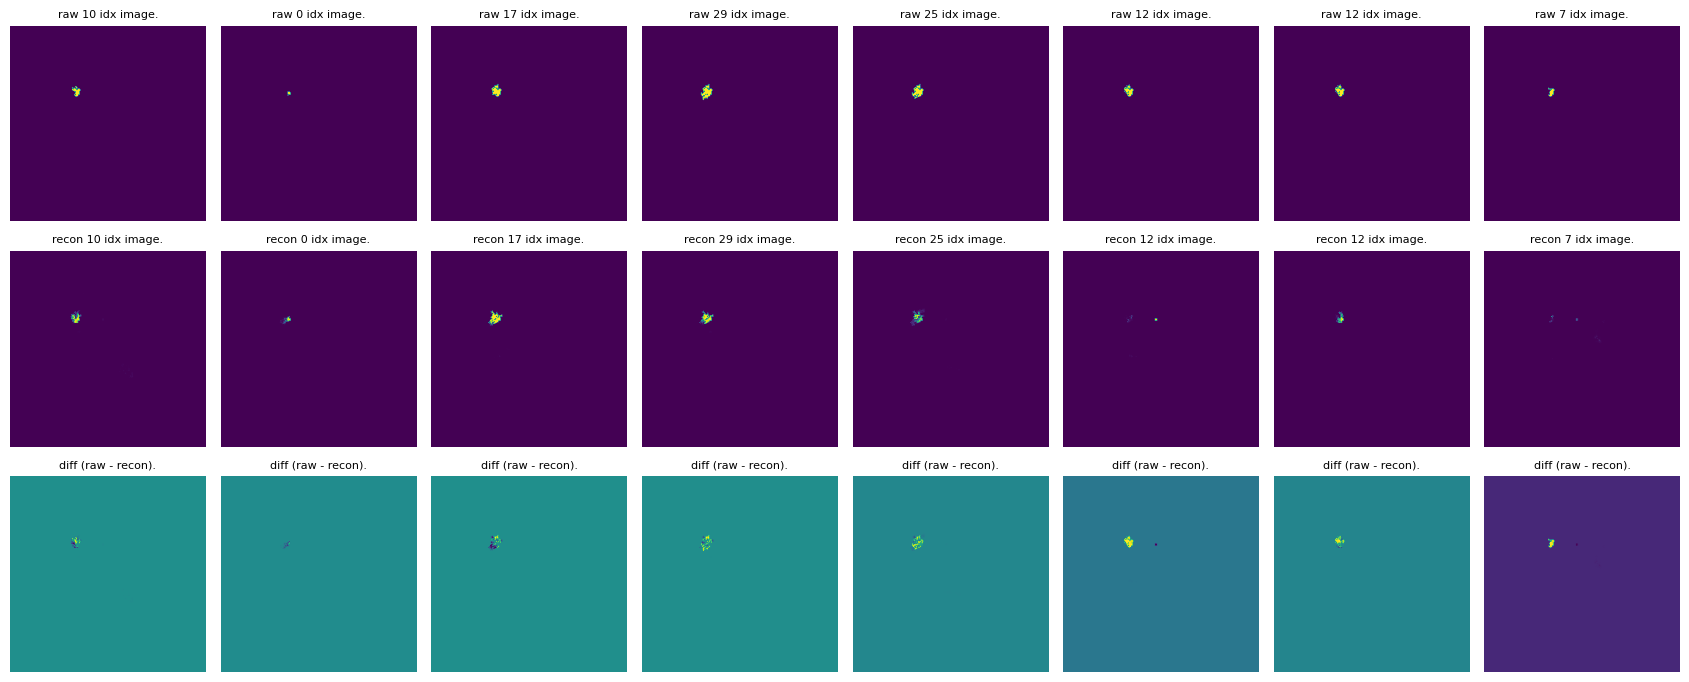

In [34]:
plot_batch_recon_images(
    model=model,
    data_loader=test_loader,
    num_images=8,
    device=DEVICE,
)

* there is definitely some artefacts in the background when reconstructing unseen test data.

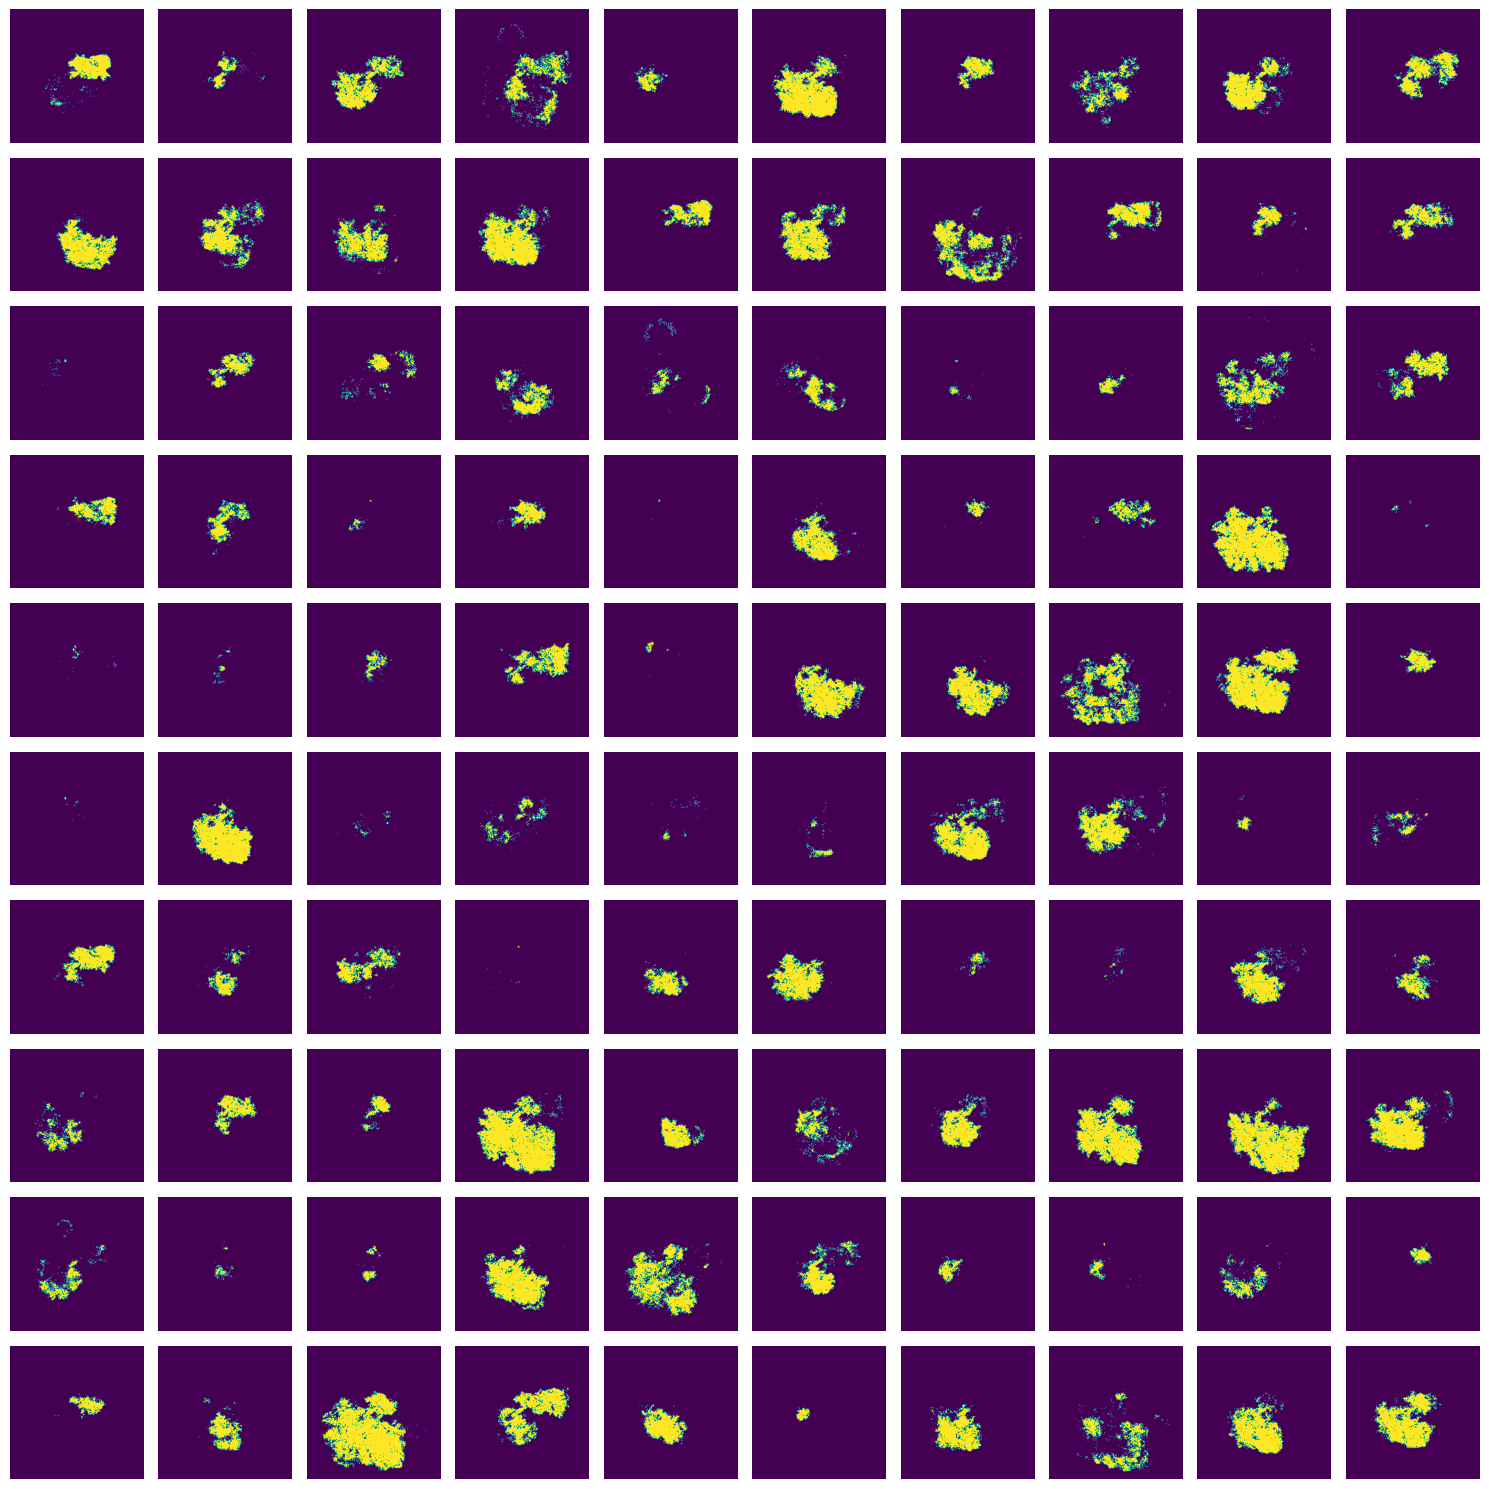

In [52]:
plot_generated_images_from_latent_space(
    model=model,
    num_samples=100,
    latent_dim=16,
    img_dims=(256, 256),
    pixel_threshold=None,
)

### Conclusions:

* The winner: `[1024 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize=32`, although producing some wildfires that look realistic definitely produces worse images that the previous "baseline": `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize = 32`. The winner arch seems to produce more background artefacts and also less clustered wildfires that expand and more spurious patters which are unrealisitc. 
* the decision is to continue the testing.
* I will keep the lr schedule in with both of the architechtures but I will revert back to `RELU`.
* both the winner and the previous baseline are very simple arcitechtures and so the decision very much lies with the generation. By that I mean, if we were considering marginal gains in image generation at the expense of only being able to use GPUs then maybe we would choose the simpler, 2 layer winner: `[1024 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize=32`